# 1. Introduction to neural networks

## Minimal neural network

Let us start by building a minimal neural network. First, run the following cell for the necessary imports (their significance will become clear later). You'll need to install the python package Tensorflow first using e.g. the Python Packages manager. With Tensorflow it is possible to access the Keras library, which specifies in creating neural networks of various types.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

Next, we download the famous MNIST dataset, which comes with Tensorflow and contains 28 x 28 pixel images of handwritten digits, labelled 0-9. The data ends up in four different NumPy tensors: `x_train` and `y_train` contain the input features and target labels for the training samples, and `x_test` and `y_test` the same for the test samples. 

The training set consists of 60000 image samples, and the test set a further 10000 samples.

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

First, we do some basic preprocessing: the input features (pixel values) originally vary in the range 0 ... 255, and these values are divided by 255 to convert them to range 0 ... 1, which has computational advantages. Also, the labels are one-hot-encoded (with the Keras function `to_categorical`) from the original integer form; this ensures that the distances between two different labels are similar. For example, the label 4 is converted to the form [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]. 

In [13]:
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Now we determine the structure (architecture) of our simple neural network. First we create an instance of class `Sequential`, which corresponds to a neural network consisting of layers stacked one after another (most of them are of this kind).

This particular neural network model has three layers; ignore their details for now, as we'll look at them more closely below.

In [14]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

Next the model needs to be compiled, which means providing the learning algorithm some information about training and performance monitoring. Again, we'll look at the details more closely below. 

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Now the model can be trained with the training data:

In [16]:
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2944 - accuracy: 0.9153 - val_loss: 0.1636 - val_accuracy: 0.9535
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1330 - accuracy: 0.9615 - val_loss: 0.1254 - val_accuracy: 0.9626
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0908 - accuracy: 0.9726 - val_loss: 0.1104 - val_accuracy: 0.9679
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0679 - accuracy: 0.9799 - val_loss: 0.1023 - val_accuracy: 0.9703
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0519 - accuracy: 0.9844 - val_loss: 0.0945 - val_accuracy: 0.9718


Now that our model has been trained, we can use it to predict the labels of the samples in the test set (which the model has so far not been exposed to), and evaluate the classification accuracy. We observe that, even this fairly simple model is able to predict the labels with accuracy that is above 97%.

In [17]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 0s 1ms/step - loss: 0.0804 - accuracy: 0.9759
Test accuracy: 0.9758999943733215


## Workflow

The simple example contains all the essential stages of deep learning experiments:

* **Download the data**: prepare separate sets for training and testing as NumPy arrays
* **Preprocess the data**: standardize/normalize input features, one-hot-encode categorical variables
* **Build the model**: define the architecture and the various layers
* **Compile the model**: give details concerning training and specify metrics
* **Train the model**: allow the learning algorithm to find good parameter values for the model
* **Evaluate the model**: test the performance with new, previously unseen data

It is useful to think of a neural network as an information-processing unit. Input data enters the network in the form of a tensor, which is a multidimensional array of numbers. The first layer of the network modifies this tensor, and outputs a new one, which then enters the second layer as an input. The data then flows through the network from one layer to the next, and gets modified every step of the way, finally coming out as predictions for the target values. In other words, a neural network aims to model the connection between the inputs and outputs.

In the example above, the first layer (the *Flatten* layer) only reshapes the input tensor. Originally, the shape of the tensor containing the input features in the training samples is 

In [23]:
x_train.shape

(60000, 28, 28)

That is, the three-dimensional input tensor contains 60000 samples, each determined by 28 times 28 pixel values: the first index determines the sample, and the second and third index point to the row and column of the collection of pixel values defining the image. The cell below shows one example of the input samples.

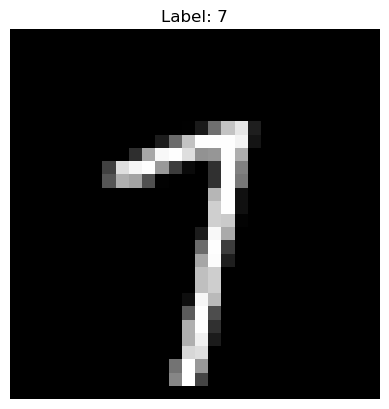

In [20]:
import matplotlib.pyplot as plt

# Visualize a sample image
sample_number = 42
plt.imshow(x_train[sample_number], cmap='gray')
plt.title(f'Label: {y_train[sample_number].argmax()}')  # Use .argmax() to get the label as an integer
plt.axis('off')  # Hide the axes
plt.show()

The first layer of the neural network model merely reshapes the input tensor from a three-dimensional to two-dimensional form: instead of a 2D table of 28 x 28 numerical values, each sample becomes a 1D vector of 28 x 28 = 784 numerical values. 

Following the Flatten layer, the above model has two additional *Dense* layers. These layers perform a somewhat more complex computation; this leads us to consider the mathematics of neural networks in more detail.

### Single neuron

Neural networks consist of a large number of similar unit entities, neurons, arranged in layers. Each of the neurons performs a similar kind of computation: it takes in a collection of input values, and produces a single number as an output. The computation takes place in two stages: 1) **weighted sum**, followed by 2) **activation function**.

Assume that an individual neuron takes in N inputs: $x_{1}, x_{2}, ..., x_{N}$. Such a neuron has N parameters called **weights**, $w_{1}, w_{2}, ..., w_{N}$, and a **bias** parameter $b$. First, the neuron computes a weighted sum $z$ of the inputs as follows:

$$
z = w_{1}x_{1} + w_{2}x_{2} + ... + w_{N}x_{N} + b
$$
After this, the final output $y$ of the neuron is obtained from

$$
y = f(z)
$$
where the function $f$ is called an **activation function**. Common choices for activation functions are the sigmoid

$$
f(z) = \frac{1}{e^{-x}+1}
$$ 
and the ReLU (rectified linear unit)

$$
f(z) = \begin{cases} 
z & \hspace{1cm} z > 0 \\
0 & \hspace{1cm} \text{otherwise} 
\end{cases} 
$$
The activation functions are typically chosen to be nonlinear (as the two examples above are) to increase the complexity of the computation performed by the neurons and, therefore, to be able to model complex behavior.

### Fully connected (Dense) layer

A **fully connected** layer (or *Dense* layers, as they are referred to in Keras) is simply a collection of several neurons, each having their individual set of weight and bias values. For example, the second layer in our model above has a total of 128 neurons. Each of these 128 neurons takes all 784 pixel values of each sample in as input; each neuron also has 128 weights and one bias value, and they compute a weighted sum of the 784 input features. Next, each of these 784 intermediate outputs are inserted in the activation function (this is the same for all 128 neurons in the layer), producing the final output of 128 values. In this way, the dense layer processes the original 1D vector of 784 values to another 1D vector of 128 values. This information then continues to the next layer as an input.

![Alt text](Images/nn.svg)

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
